In [1]:
import os
import datetime
import math
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
    
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# DATA
df1 = pd.read_csv('data_day.csv')
df2 = pd.read_csv('data_2018-08-05_2021-04-30.csv')
df3 = pd.read_csv('data_2018-05-05_2018-08-04.csv')
df4 = pd.read_csv('data_2015-08-09_2018-05-04.csv')
df5 = pd.read_csv('data_2013-02-12_2015-08-08.csv')
df6 = pd.read_csv('data_2010-05-19_to_2013-02-11.csv')
df7 = pd.read_csv('data_2007-08-23_to_2010-05-18.csv')
df8 = pd.read_csv('data_2004-11-26_to_2007-08-22.csv')
df = pd.concat([df6, df5, df4, df3, df2, df1])
df.index = range(0,4996)
df.tail()

date_time = pd.concat([pd.to_datetime(df['datetime'][0:4000]),pd.to_datetime(df['datetime'][4000:])])
data_use = df[['temp','tempmax', 'tempmin','humidity', 'precip', 'windspeed', 'solarradiation', 'solarenergy']]
print(data_use)

      temp  tempmax  tempmin  humidity  precip  windspeed  solarradiation  \
0     30.8     36.5     26.0      78.1   0.000       20.5           301.4   
1     31.3     36.4     27.0      76.0   0.300       24.1           281.5   
2     30.7     39.0     26.0      76.1   2.300       40.7           237.1   
3     31.5     39.6     26.0      71.2   0.800       15.1           296.8   
4     27.6     30.8     25.8      80.1  33.000       22.7           240.8   
...    ...      ...      ...       ...     ...        ...             ...   
4991  20.5     22.0     19.5      93.8   8.794       17.5           148.7   
4992  22.4     26.5     20.0      84.5   0.683       19.4           140.8   
4993  22.6     26.6     20.0      85.5   0.072       20.3           131.9   
4994  23.0     26.0     19.0      82.4   3.300       20.5            63.7   
4995  16.0     18.0     14.0      91.4   3.400       22.3            15.8   

      solarenergy  
0            26.1  
1            24.3  
2            20

In [3]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s[1] - timestamp_s[0]

86400.0

C:\Users\tridu\AppData\Local\Temp\ipykernel_23240\1206436225.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
C:\Users\tridu\AppData\Local\Temp\ipykernel_23240\1206436225.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


Index(['temp', 'tempmax', 'tempmin', 'humidity', 'precip', 'windspeed',
       'solarradiation', 'solarenergy', 'Year sin', 'Year cos'],
      dtype='object')

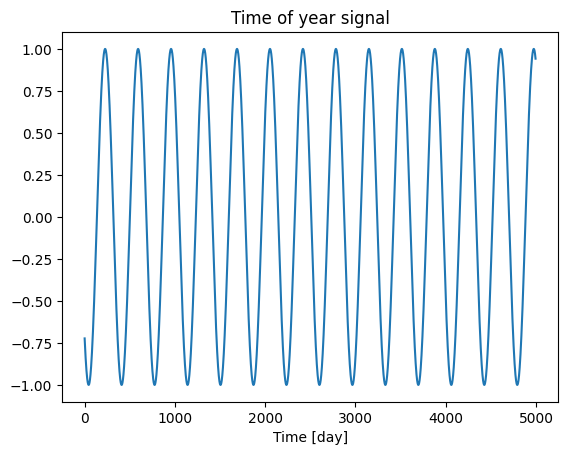

In [4]:
# PERIOD TIME

day = 24*60*60
year = (365.2425)*day
# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# plt.plot(np.array(df['Year sin'])[:366])
plt.plot(np.array(data_use['Year cos'])[:])
plt.xlabel('Time [day]')
plt.title('Time of year signal')
data_use.columns

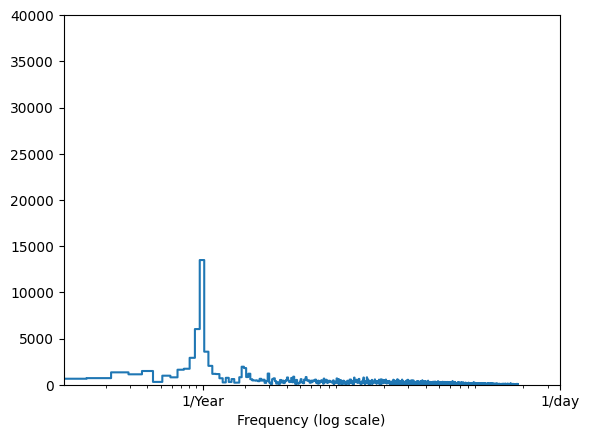

In [5]:
fft = tf.signal.rfft(data_use['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_day = len(data_use['humidity'])
days_per_year = 365.2524
years_per_dataset = n_samples_day/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [6]:
number_train = int(data_use.shape[0] * 0.8)
train, test = data_use[0:number_train], data_use[number_train:]

In [7]:
def create_data(in_steps, out_steps, data, feature):
    X = []
    y = []
    for i in range(len(data)-in_steps-out_steps):
        X.append(data[i:i+in_steps])
        y.append(data[i+in_steps:i+in_steps+out_steps][feature])
    return np.array(X), np.array(y)
def normalize(data, train_mean, train_std):
    data_norm = (data - train_mean)/train_std
    return data_norm
def unnormalize(data, train_mean, train_std):
    data_unnorm = (data * train_std) + train_mean
    return data_unnorm


In [8]:
in_steps = 180
out_steps = 14

In [9]:
X_train, y_train = create_data(in_steps, out_steps, train, ['temp','humidity'])
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 2)

X_test, y_test = create_data(in_steps, out_steps, test, ['temp','humidity'])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 2)

X_train_norm = normalize(X_train, X_train.mean(), X_train.std())
y_train_norm = normalize(y_train, y_train.mean(), y_train.std())

X_test_norm = normalize(X_test, X_train.mean(), X_train.std())
y_test_norm = normalize(y_test, y_train.mean(), y_train.std())

print(X_train_norm.shape, y_train_norm.shape, X_test_norm.shape, y_test_norm.shape)


(3802, 180, 10) (3802, 14, 2) (806, 180, 10) (806, 14, 2)


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(out_steps*2),
    tf.keras.layers.Reshape([out_steps, 2])
])



In [14]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Lion(learning_rate = 0.001),
)

In [15]:
history = model.fit(X_train_norm, y_train_norm, epochs=30, validation_split=0.2, batch_size=32, validation_batch_size=32)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.2793 - val_loss: 0.0874
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.0803 - val_loss: 0.1106
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 0.0727 - val_loss: 0.0760
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.0664 - val_loss: 0.0806
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.0668 - val_loss: 0.0799
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0635 - val_loss: 0.0806
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0641 - val_loss: 0.0727
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0631 - val_loss: 0.0742
Epoch 9/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0625 - val_loss: 0.0741
Epoch 10/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.0622 - val_loss: 0.0701
Epoch 11/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0613 - val_loss: 0.0695
Epoch 12/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 10

In [20]:
model.save('lstm180-not_overfit.keras')

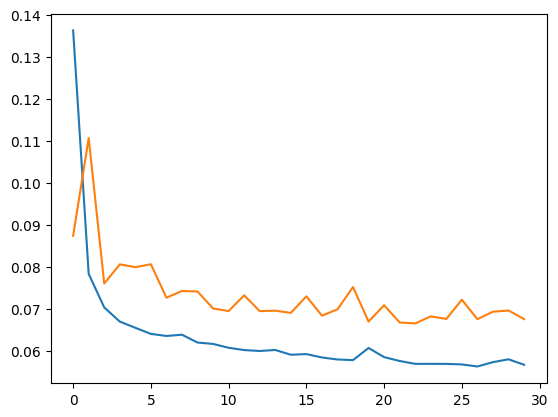

In [16]:
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])

In [17]:
model.evaluate(X_test_norm, y_test_norm)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0891


0.08977281302213669

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Day:  1
MAE:  1.6270815761746011
MSE:  4.746912023234502
CORR:  0.9352847545167498
Day:  2
MAE:  2.3451298706584773
MSE:  10.287163501199855
CORR:  0.8546477956385597
Day:  3
MAE:  2.3672445410830214
MSE:  9.010447329874928
CORR:  0.8541849963250322
Day:  4
MAE:  2.3891403851378943
MSE:  9.242975837089993
CORR:  0.8392576693606244
Day:  5
MAE:  2.280566846880664
MSE:  8.415473050863126
CORR:  0.838557295418248
Day:  6
MAE:  2.3225093472388485
MSE:  8.83098070832619
CORR:  0.8322968711995445
Day:  7
MAE:  2.4372869420584022
MSE:  9.68431309060942
CORR:  0.8249459948511173
Day:  8
MAE:  2.4129283644721173
MSE:  9.416646782172343
CORR:  0.8237686775272504
Day:  9
MAE:  2.6019237262735295
MSE:  11.007470814632136
CORR:  0.8213328402468465
Day:  10
MAE:  2.581727458584693
MSE:  10.756929889312525
CORR:  0.8181560843047428
Day:  11
MAE:  2.5883000494528643
MSE:  10.694557079289302
CORR:  0.8141887829900588
Day:  12
MAE:  2.652020375367725
MSE:  11.0646

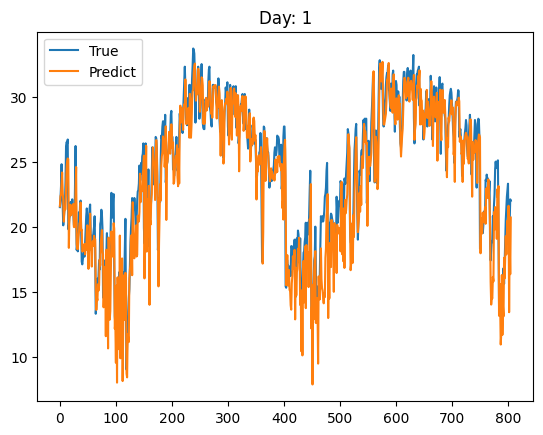

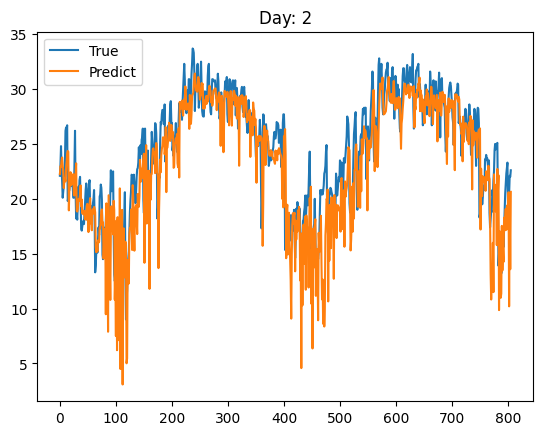

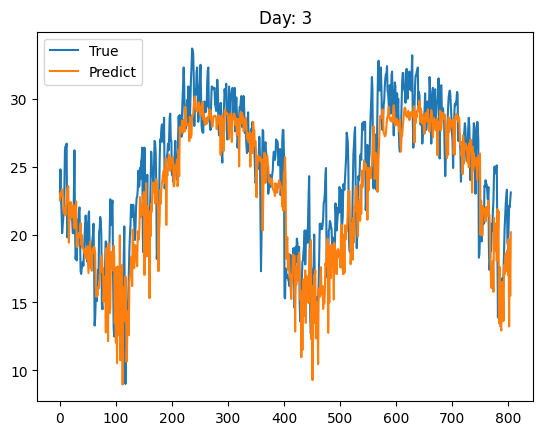

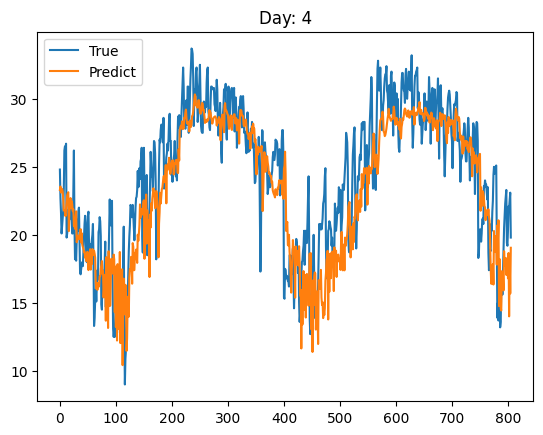

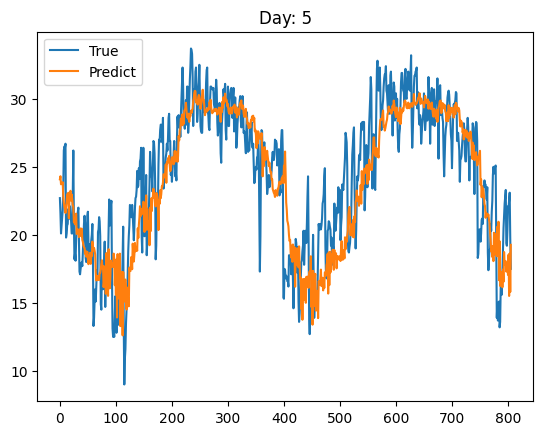

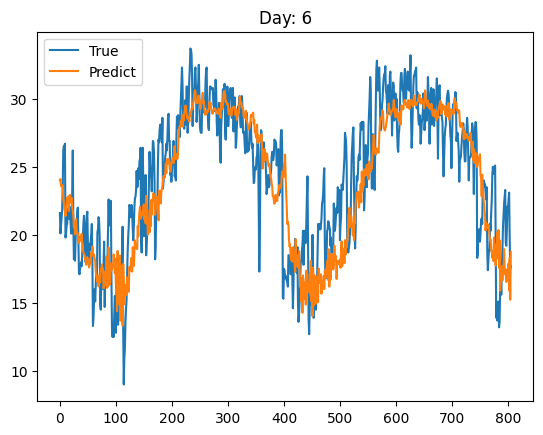

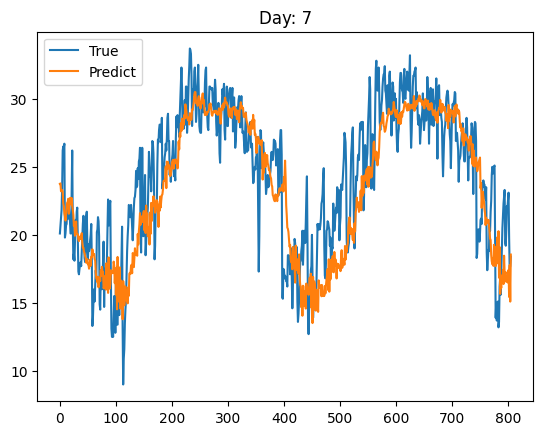

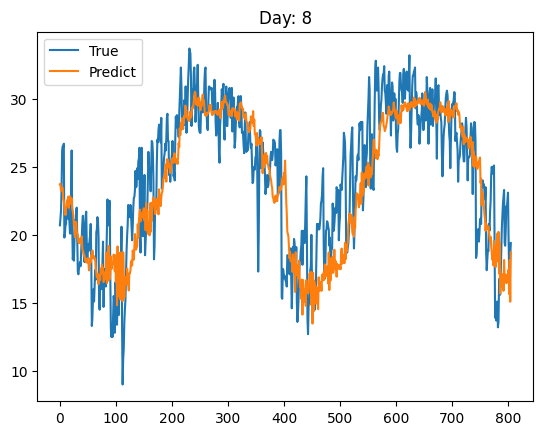

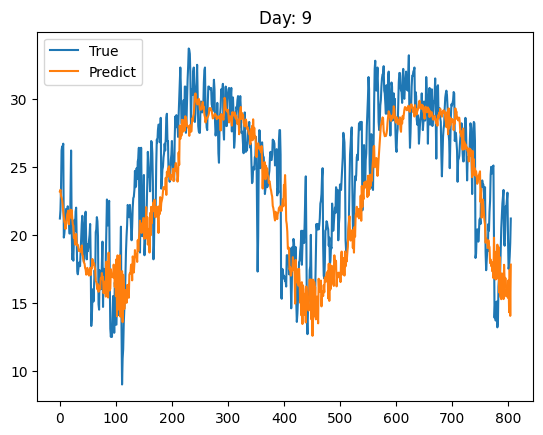

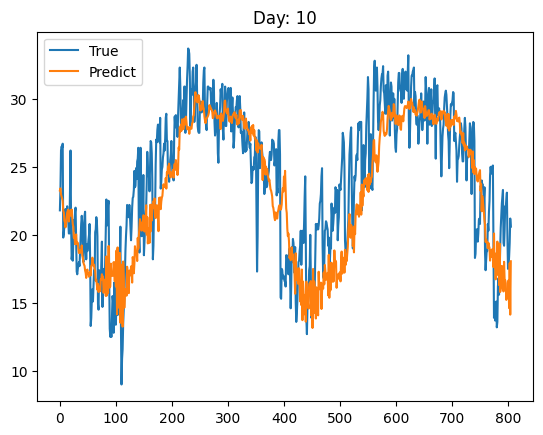

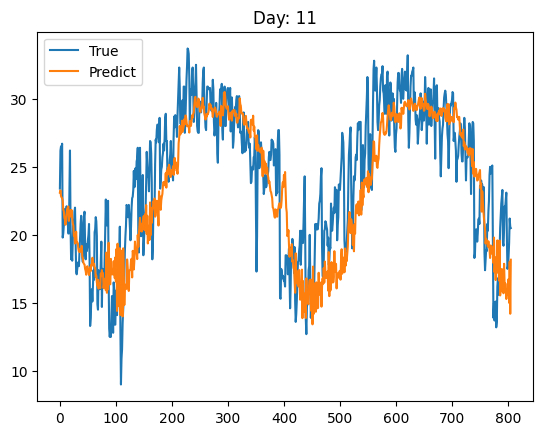

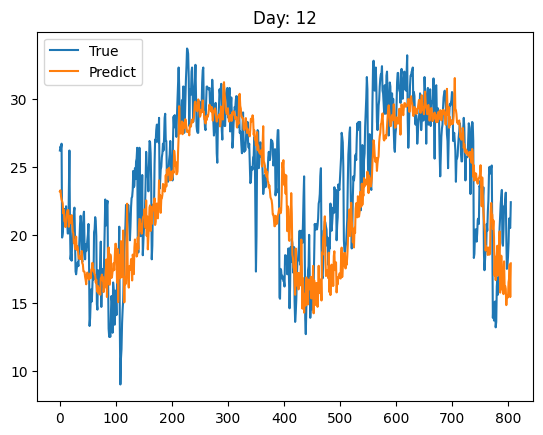

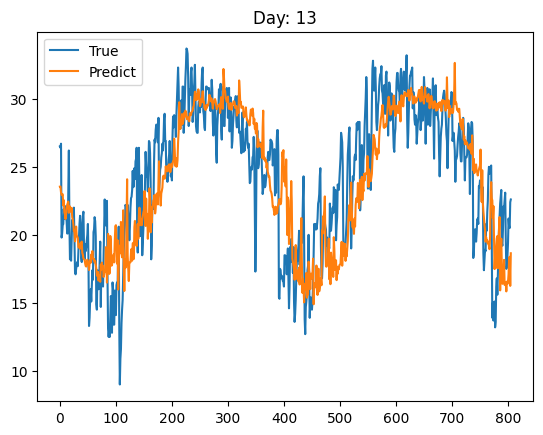

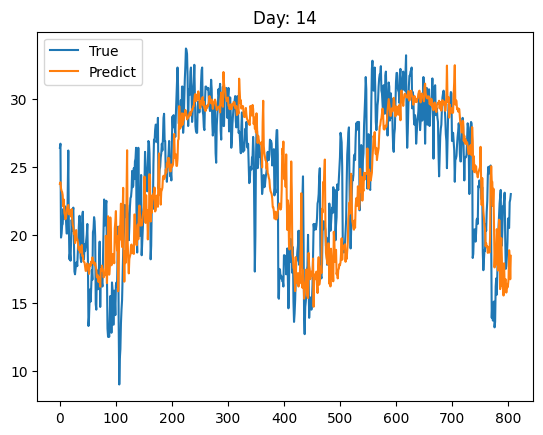

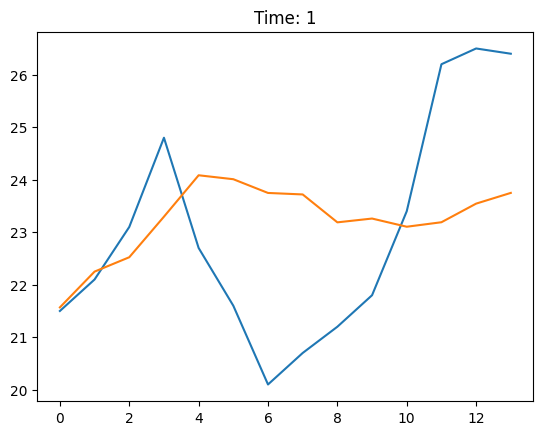

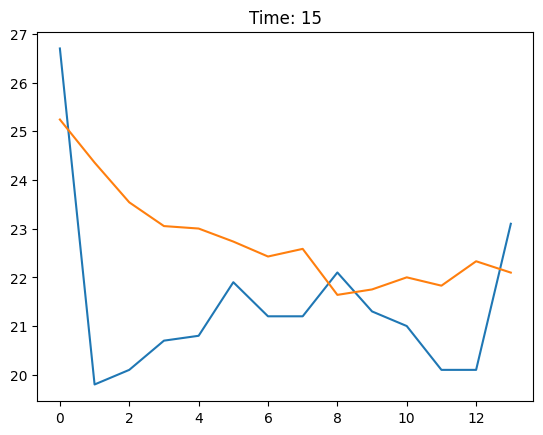

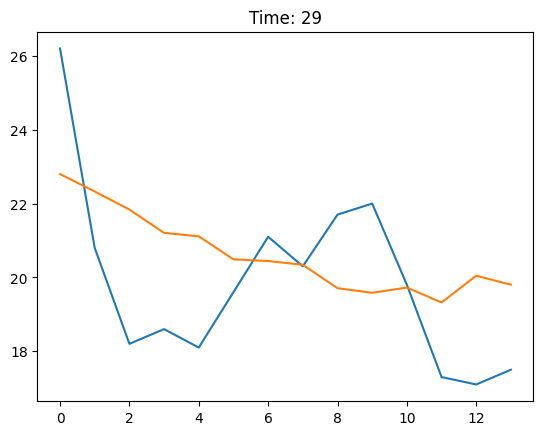

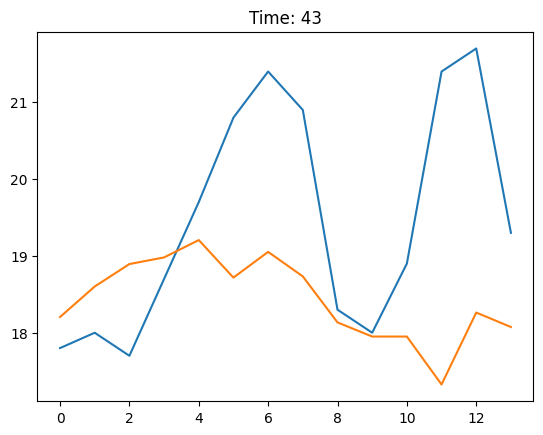

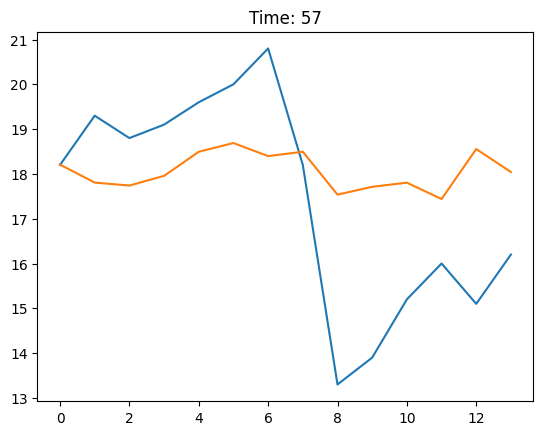

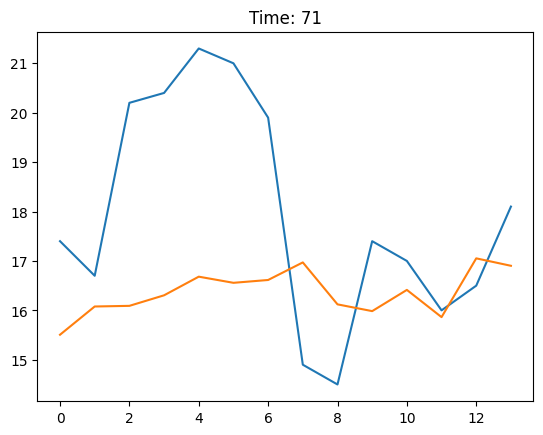

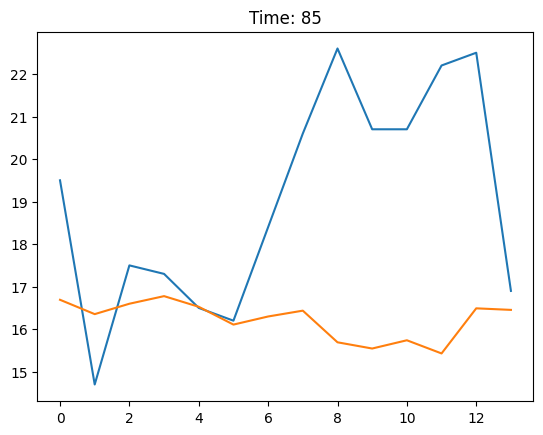

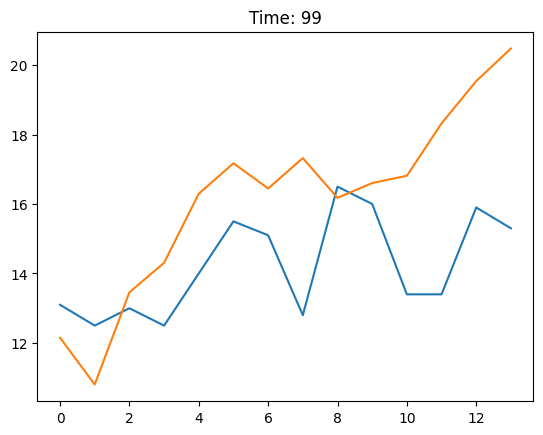

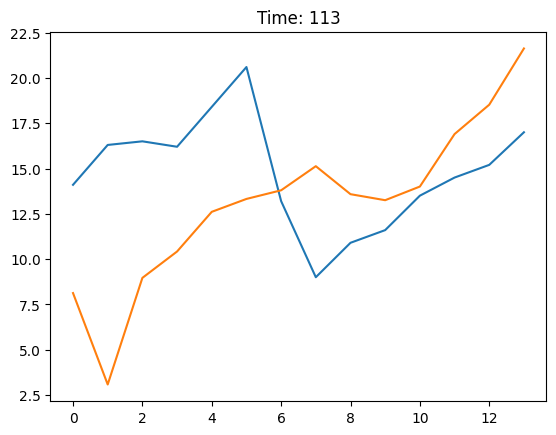

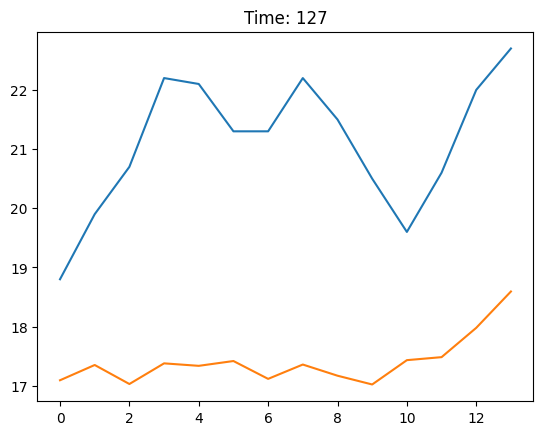

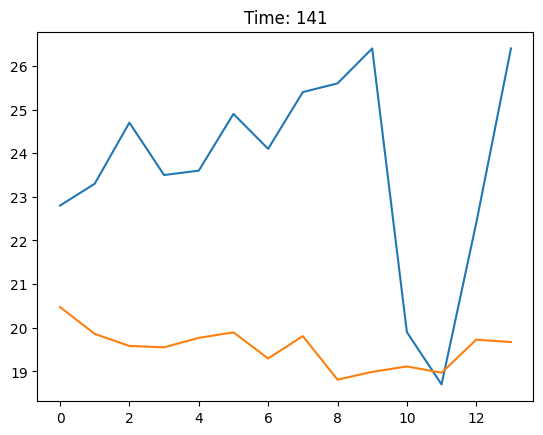

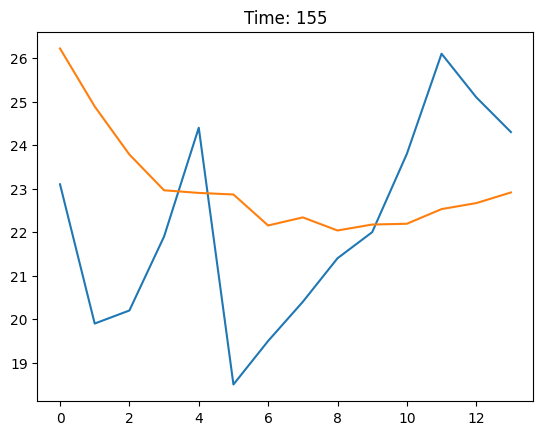

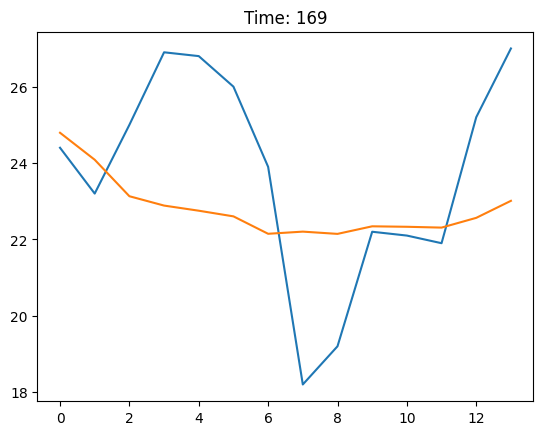

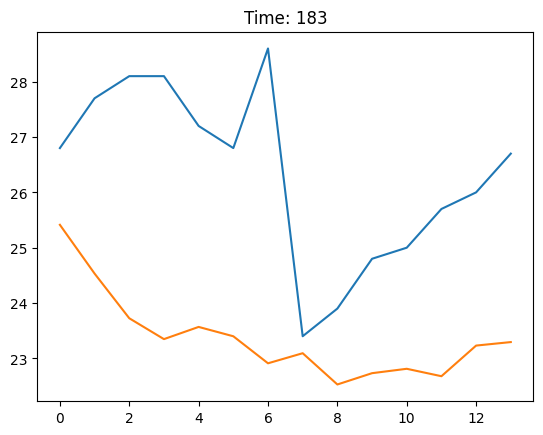

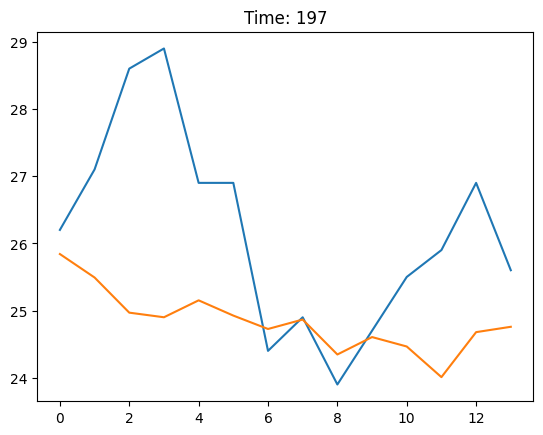

In [19]:
predict = model.predict(X_test_norm)
predict_unnorm = unnormalize(predict, y_train.mean(), y_train.std())
y_test_unnorm = unnormalize(y_test_norm, y_train.mean(), y_train.std())
plt.legend(['Predict', 'True'])
for i in range(14):
    print('Day: ', i+1)
    print('MAE: ', mean_absolute_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('MSE: ', mean_squared_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('CORR: ', np.corrcoef(y_test_unnorm[:,i,0], predict_unnorm[:,i,0])[0,1])
for i in range(14):
    plt.title('Day: ' + str(i+1))
    plt.plot(y_test_unnorm[:,i,0])
    plt.plot(predict_unnorm[:,i,0])
    plt.legend(['True', 'Predict'])
    plt.show()
for i in range(0, 200, 14):
    plt.title('Time: ' + str(i+1))
    plt.plot(y_test_unnorm[i,:,0])
    plt.plot(predict_unnorm[i,:,0])
    plt.show()